# Example : Measurement campaign

This example represent a sensor measurement campaign.

It shows that :
- data can simply be represented in multidimensional format and used in Xarray
- the multidimensional JSON format is the most compact of the usual formats (tabular JSON, CSV and even Parquet).

## use case description

Sensors are installed in five French cities (lille, toulouse, marseille, strasbourg, brest) and measure air quality for ten days.
The measurement is the hourly average of pollutant concentrations (PM10, PM2.5, NO2, O3, CO).

The result of the acquisition is a table where the fields are:

- camp : description of the campaign
- date : date of measurement
- hour : hour of measurement
- city : sensor location
- coord : sensor coordinate
- prop : measured property
- unit : unit of measurement
- value : value of measurement

## data acquisition

This section is a simulation of the data acquisition by sensors.
The result of the campaign is a pandas DataFrame.

In [1]:
import os
from random import random

columns = ['camp', 'date', 'hour', 'city', 'coord', 'prop', 'unit', 'value']

camp = 'air quality sensor measurement'
dates = ['2024/05/24', '2024/05/25', '2024/05/26', '2024/05/27', '2024/05/28', 
         '2024/05/29', '2024/05/30', '2024/05/31', '2024/06/01', '2024/06/02',
         '2024/06/03', '2024/06/04', '2024/06/05', '2024/06/06', '2024/06/07',
         '2024/06/08', '2024/06/09', '2024/06/10', '2024/06/11', '2024/06/12']
cities = ['lille', 'toulouse', 'marseille', 'strasbourg', 'brest']
coordinates = ['[3.06, 50.63]', '[1.44, 43.6]', '[5.37, 43.3]', '[7.75, 48.57]', '[4.49, 48.39]']
properties = ['PM10', 'PM2.5', 'NO2', 'O3', 'CO']
units = ['µg/m3', 'µg/m3', 'µg/m3', 'µg/m3', 'mg/m3']
hours = list(range(24))

def data_acquisition(n_dates, n_round=None, n_hours=24):
    '''return a list of records for a set of dates defined by the n_dates parameter.
    The n_round parameter defines the type of the measurement value: 
        n_round : None -> integer
        n_round : 0    -> float
        n_round : n    -> round(float, n)'''
    return [(camp, date, hour, city, coord, prop, unit, random()*10 if n_round == 0 else round(random()*10, n_round))
             for city, coord in zip(cities, coordinates)
                 for date in dates[:n_dates]
                     for hour in hours[:n_hours]
                         for prop, unit in zip(properties, units) ]

In [2]:
import pandas as pd

meas_df_10 = pd.DataFrame(data_acquisition(10), columns=columns).sample(frac=1).reset_index(drop=True)
meas_df_10

,camp,date,hour,city,coord,prop,unit,value
0,air quality sensor measurement,2024/05/27,14,lille,"[3.06, 50.63]",NO2,µg/m3,6
1,air quality sensor measurement,2024/05/30,18,toulouse,"[1.44, 43.6]",PM10,µg/m3,1
2,air quality sensor measurement,2024/06/02,16,marseille,"[5.37, 43.3]",CO,mg/m3,6
3,air quality sensor measurement,2024/06/02,11,lille,"[3.06, 50.63]",O3,µg/m3,2
4,air quality sensor measurement,2024/05/31,14,marseille,"[5.37, 43.3]",NO2,µg/m3,6
...,...,...,...,...,...,...,...,...
5995,air quality sensor measurement,2024/05/28,20,strasbourg,"[7.75, 48.57]",O3,µg/m3,3
5996,air quality sensor measurement,2024/05/27,23,toulouse,"[1.44, 43.6]",O3,µg/m3,9
5997,air quality sensor measurement,2024/06/02,10,lille,"[3.06, 50.63]",O3,µg/m3,0
5998,air quality sensor measurement,2024/06/02,13,toulouse,"[1.44, 43.6]",O3,µg/m3,9


## Multidimensional representation

The DataFrame is simply converted to an Xarray.

In [3]:
import xarray as xr
import ntv_pandas

meas_xr_10 = meas_df_10.npd.to_xarray()
meas_xr_10

<xarray.Dataset> Size: 49kB
Dimensions:  (date: 10, hour: 24, city: 5, prop: 5)
Coordinates:
  * city     (city) <U10 200B 'brest' 'lille' ... 'strasbourg' 'toulouse'
  * date     (date) <U10 400B '2024/05/24' '2024/05/25' ... '2024/06/02'
  * hour     (hour) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * prop     (prop) <U5 100B 'CO' 'NO2' 'O3' 'PM10' 'PM2.5'
    coord    (city) <U13 260B '[4.49, 48.39]' '[3.06, 50.63]' ... '[1.44, 43.6]'
    unit     (prop) <U5 100B 'mg/m3' 'µg/m3' 'µg/m3' 'µg/m3' 'µg/m3'
    camp     <U30 120B 'air quality sensor measurement'
Data variables:
    value    (date, hour, city, prop) int64 48kB 9 0 5 7 1 6 3 ... 0 5 3 3 4 4 8

In [4]:
meas_xr_10.sel(city='lille', prop='NO2', hour=0, date='2024/05/24').values

<bound method Mapping.values of <xarray.Dataset> Size: 308B
Dimensions:  ()
Coordinates:
    city     <U10 40B 'lille'
    date     <U10 40B '2024/05/24'
    hour     int64 8B 0
    prop     <U5 20B 'NO2'
    coord    <U13 52B '[3.06, 50.63]'
    unit     <U5 20B 'µg/m3'
    camp     <U30 120B 'air quality sensor measurement'
Data variables:
    value    int64 8B 3>

## JSON representation

The multidimensional JSON is a JsonObject where members are columns of the DataFrame.

In [5]:
from pprint import pprint

notype = [True]*len(meas_df_10.columns)
meas_df_1 = pd.DataFrame(data_acquisition(1, n_round=2, n_hours=4), columns=columns).sample(frac=1).reset_index(drop=True)
meas_xr_1 = meas_df_1.npd.to_xarray()
meas_json = meas_xr_1.nxr.to_json(notype=notype, header=False, encoded=False)
pprint(meas_json, compact=True)

{'camp': [[['air quality sensor measurement']]],
 'city': [[['brest', 'lille', 'marseille', 'strasbourg', 'toulouse']]],
 'coord': [[['[4.49, 48.39]', '[3.06, 50.63]', '[5.37, 43.3]', '[7.75, 48.57]',
             '[1.44, 43.6]']],
           ['city']],
 'date': [[['2024/05/24']]],
 'hour': [[[0, 1, 2, 3]]],
 'prop': [[['CO', 'NO2', 'O3', 'PM10', 'PM2.5']]],
 'unit': [[['mg/m3', 'µg/m3', 'µg/m3', 'µg/m3', 'µg/m3']], ['prop']],
 'value': [[[4, 5, 5],
            [7.72, 6.01, 3.44, 0.89, 6.81, 6.58, 0.18, 6.87, 2.36, 8.8, 3.53,
             4.38, 2.35, 2.36, 0.76, 6.29, 3.57, 4.16, 9.29, 1.77, 2.29, 5.92,
             0.68, 0.38, 8.01, 5.22, 7.06, 9.32, 8.29, 0.16, 1.7, 5.54, 5.8,
             9.28, 8.27, 3.03, 0.75, 7.72, 3.09, 9.53, 8.4, 3.75, 6.8, 6.25,
             6.42, 5.51, 3.25, 3.05, 8.38, 7.23, 0.95, 3.11, 1.02, 4.35, 8.92,
             8.98, 7.14, 8.87, 5.0, 5.87, 4.15, 1.87, 0.16, 4.96, 7.31, 8.95,
             1.99, 3.49, 2.61, 6.18, 5.72, 3.93, 1.44, 5.2, 3.74, 9.47, 3.45,


## data size

The multidimensional JSON size is smaller than the tabular JSON size, csv size and parquet size

In [6]:
import matplotlib.pyplot as plt
import ntv_numpy
import cbor2

notype = [True]*len(meas_df_10.columns)

def file_sizes(df):
    '''calculate the size of each format'''
    return {'pd.to_json(values)': len(df.to_json(orient='values')),
            'pd.to_csv': len(df.to_csv()),
            'pd.to_parquet': len(df.to_parquet(engine='pyarrow')),
            'nxr.to_json': len(df.npd.to_xarray().nxr.to_json(notype=notype, header=False, encoded=True)),
            'nxr.to_json(cbor)': len(cbor2.dumps(df.npd.to_xarray().nxr.to_json(notype=notype, header=False, encoded=False)))}

def sizes_plot(sizes, titles, fig_title):
    '''plot the size of some format''' 
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    fig.suptitle(fig_title)
    for idx, (size, title) in enumerate(zip(sizes, titles)):
        bar_colors = ['tab:red' if val == min(size.values()) else 'tab:blue' for val in size.values()]
        percent = [str(round(val / list(size.values())[1] * 100, 1)) + ' %' for val in size.values()]
        bar_plt = axs[idx].bar(size.keys(), size.values(), color=bar_colors)
        axs[idx].set_title(title)
        axs[idx].bar_label(bar_plt, percent, label_type='center')
        axs[idx].tick_params(axis='x', rotation=55)
    plt.show()

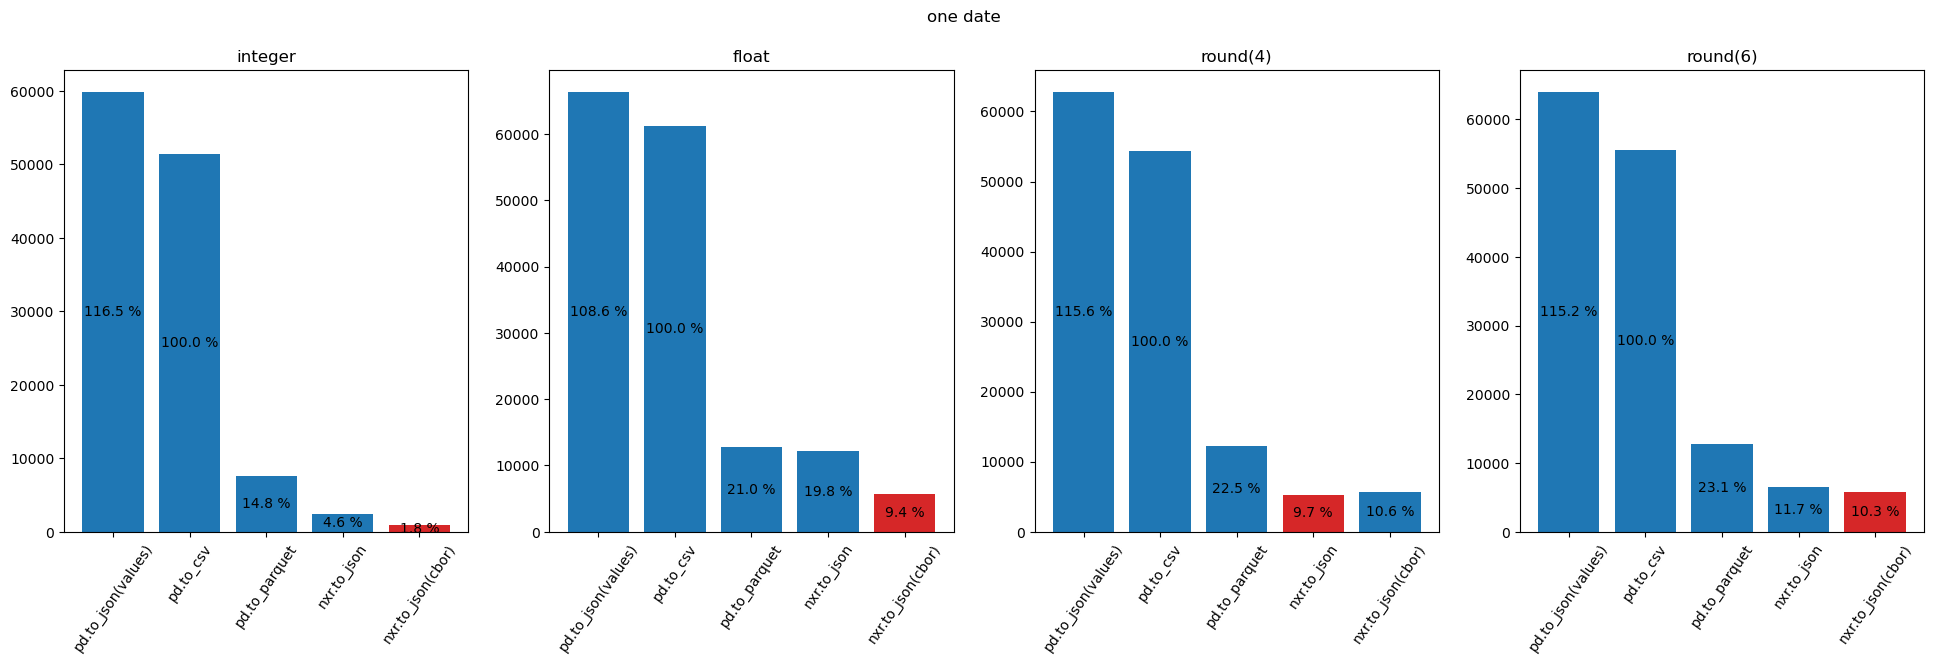

In [7]:
# plot measurement of one date
options = [(None, "integer"), (0, "float"), (4, "round(4)"), (6, "round(6)")]
sizes = [file_sizes(pd.DataFrame(data_acquisition(1, opt[0]), columns=columns).sample(frac=1).reset_index(drop=True)) for opt in options]
titles = [opt[1] for opt in options]
sizes_plot(sizes, titles, 'one date')

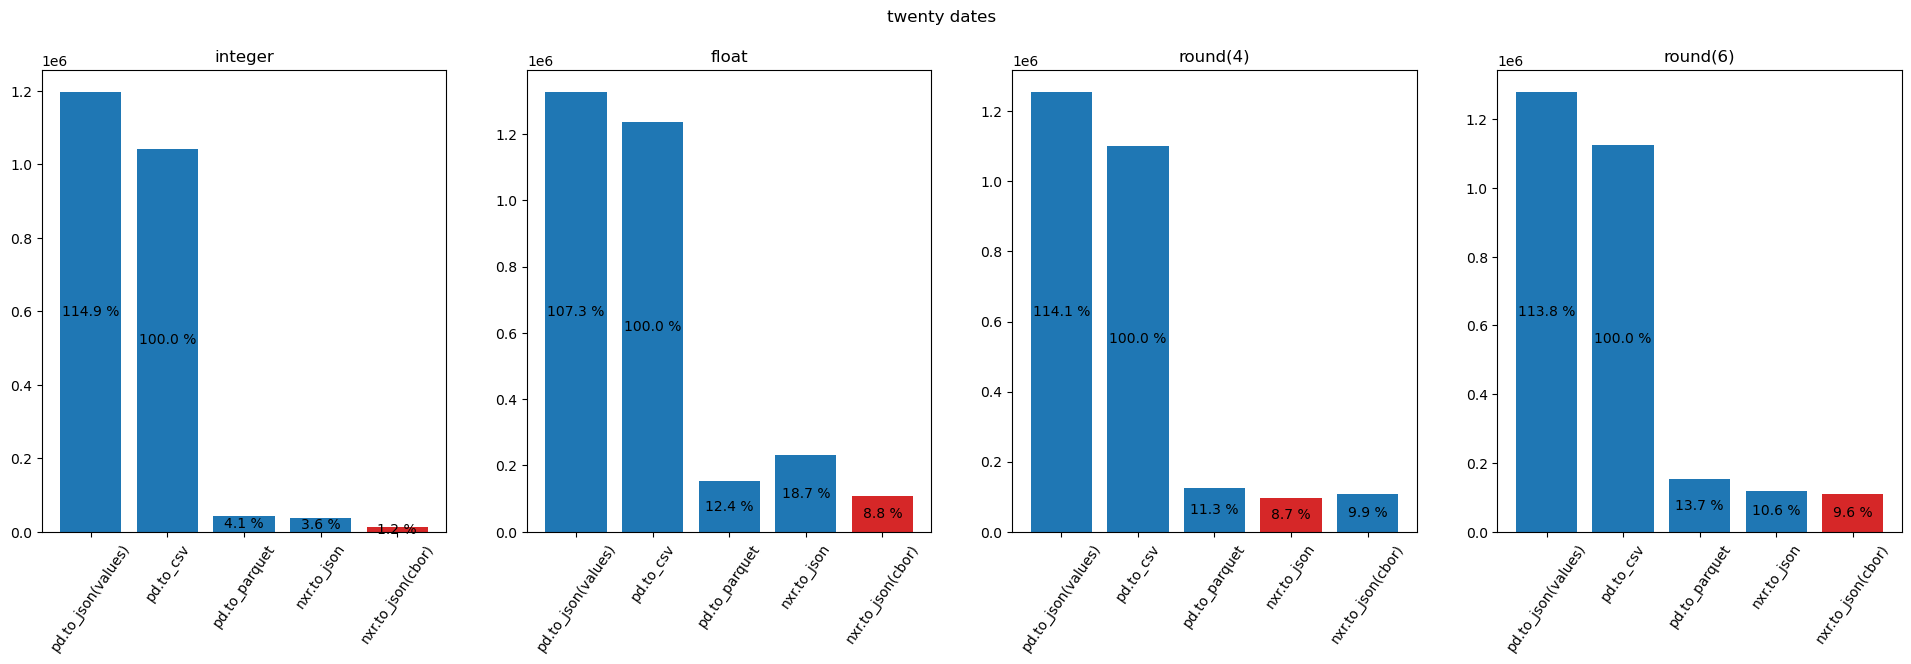

In [8]:
# plot measurement of twenty dates
sizes = [file_sizes(pd.DataFrame(data_acquisition(20, opt[0]), columns=columns).sample(frac=1).reset_index(drop=True)) for opt in options]
titles = [opt[1] for opt in options]
sizes_plot(sizes, titles, 'twenty dates')